In [1]:
import subprocess
import yaml
import requests
import textwrap
import json
from IPython.display import Image
import time

# Question and Answering inference application

In the huggingface-question-answering/pipeline/question-answering notebook, we trained and deployed an inference server (containing a distillbert model) that can be used for question and answering.

This notebook will deploy an application that uses the inference server to answer questions.

The application will:
* Accept a question
* Find the entity of the question (using spacy language models)
* Retrieve the conext for the entity from Wikipedia
* Tokenize question & context
* Invoke the inference service
* Interpret the service's response

Figure 1 shows a drawing of the application.


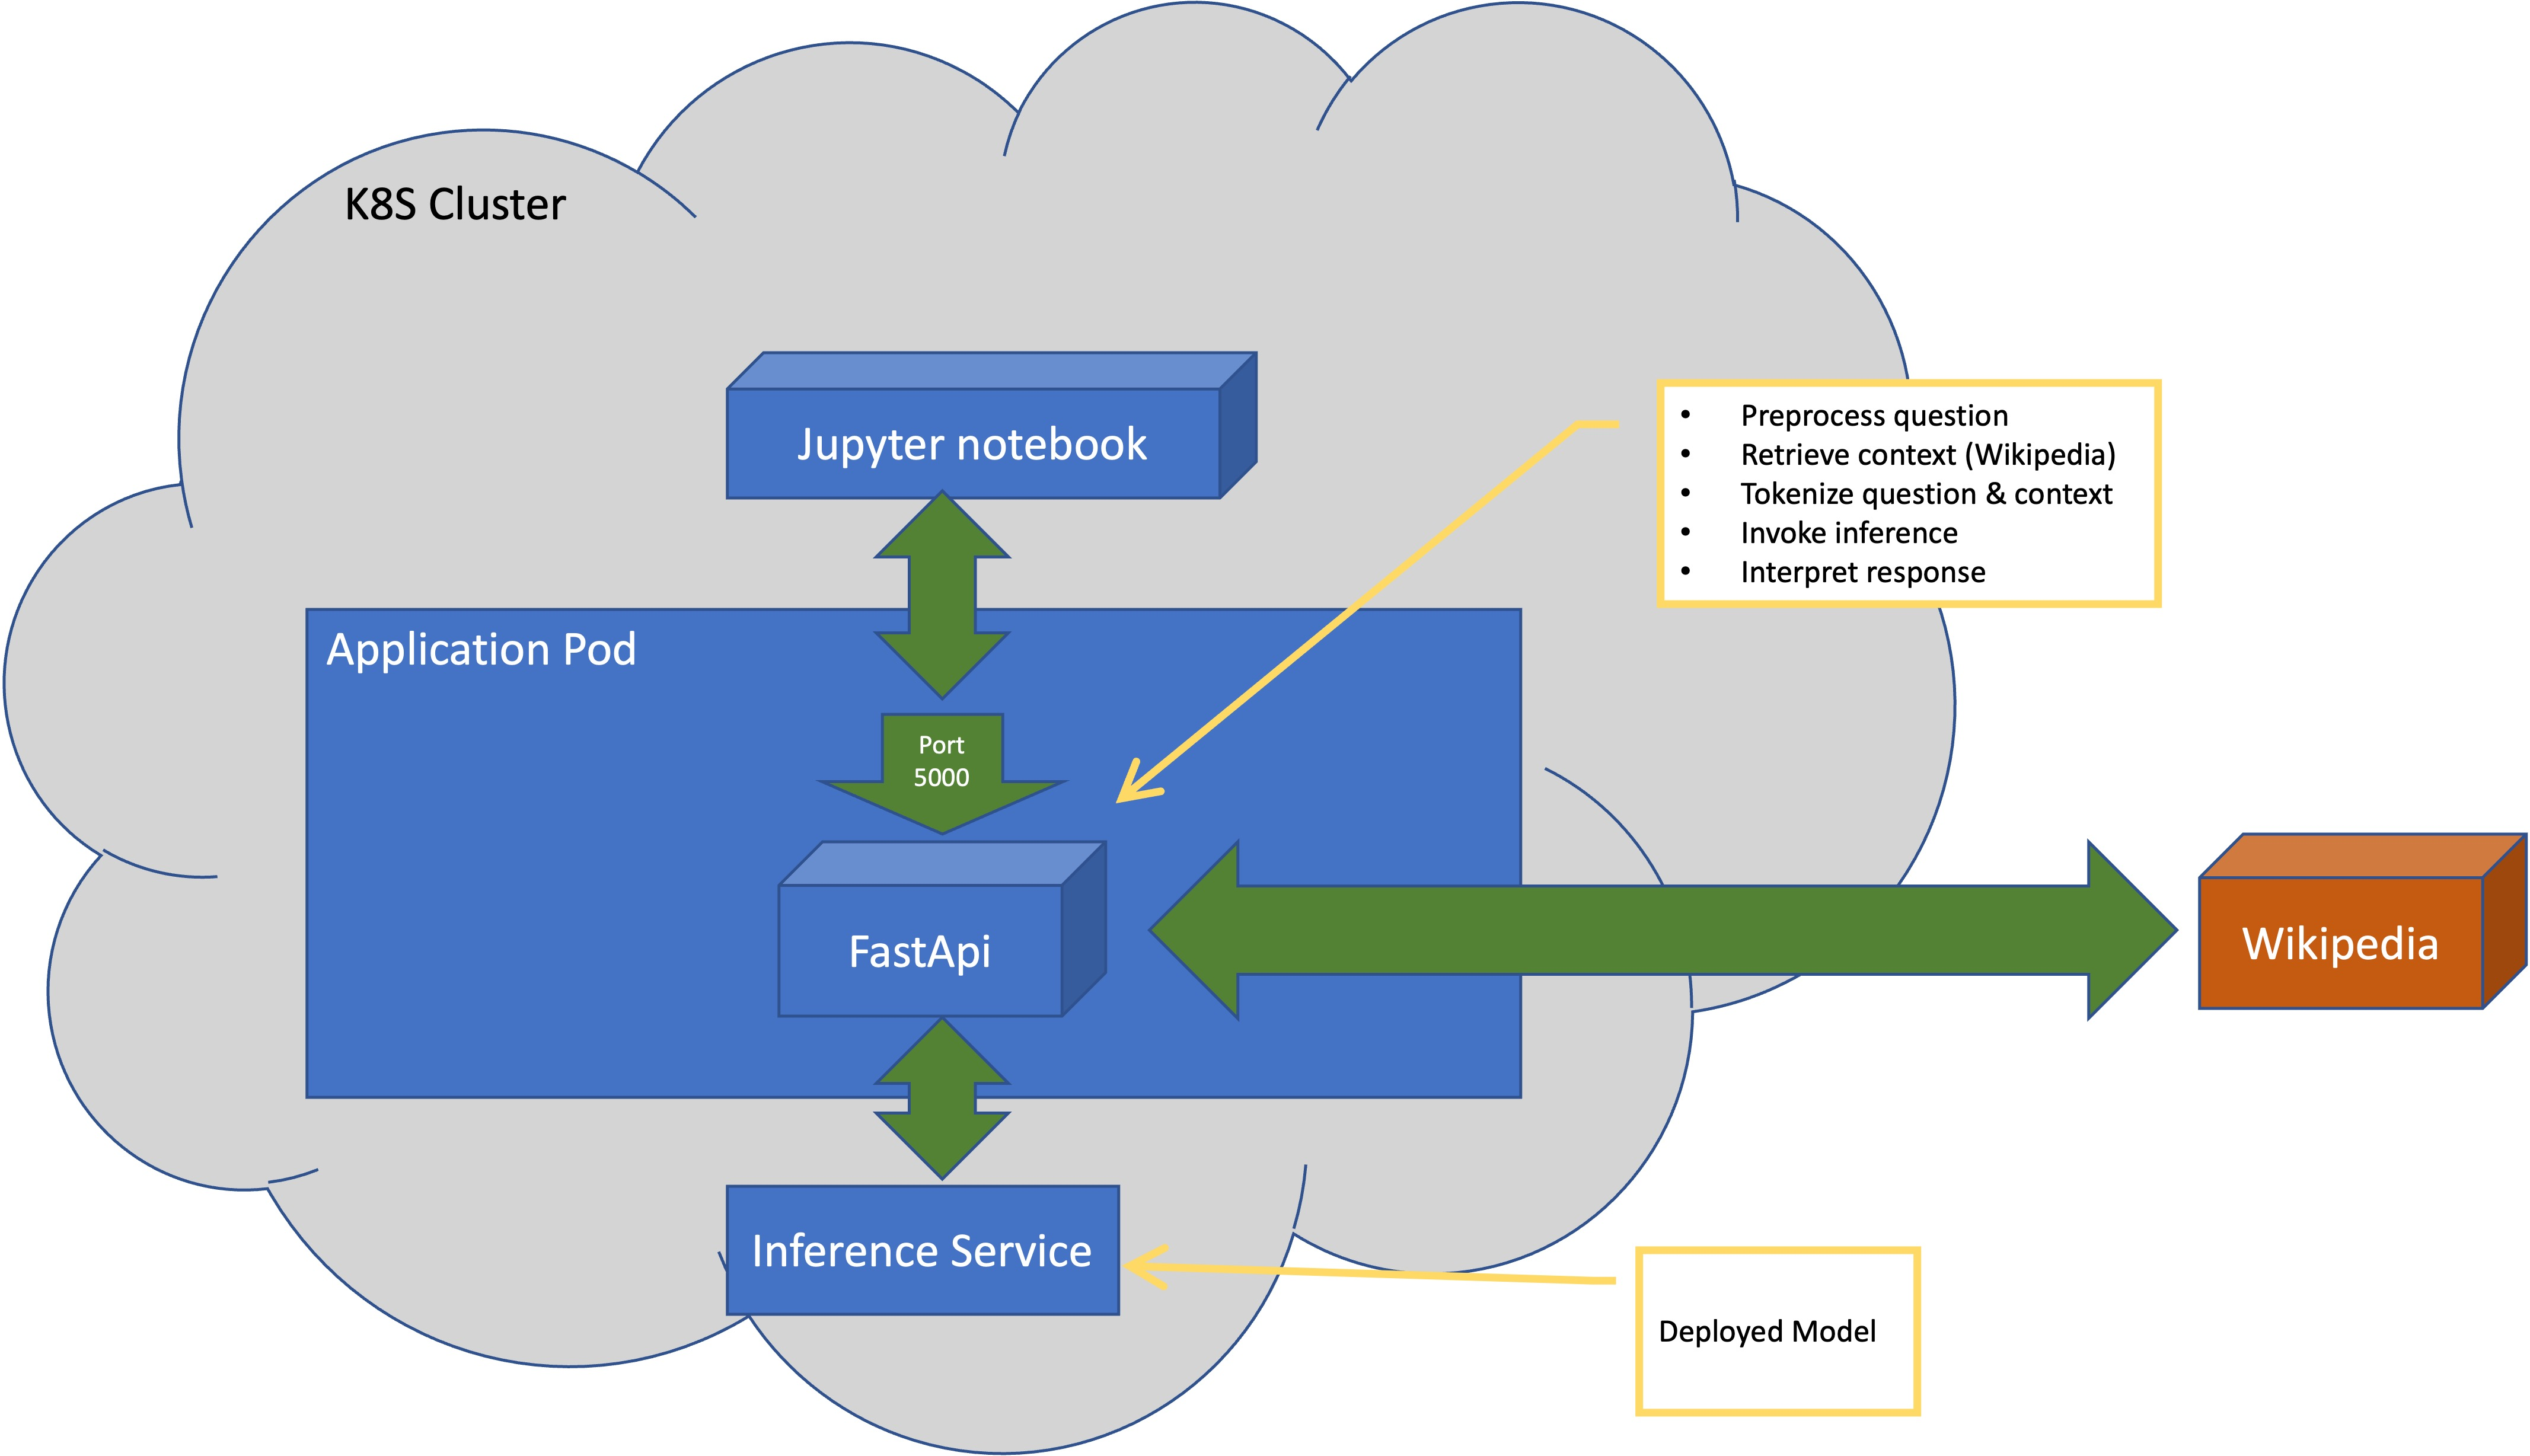

Figure 1 - Application components and interactions


In [2]:
i = Image(filename="Application.jpg", width=800, alt='Drawing of application')
display(i)
print('Figure 1 - Application components and interactions')

## Inference Service name and model name

Kubeflow has defined a k8s custom resource for `InferenceService`.

Our question and answering pipeline has deployed an InferenceService, with our trained model "preloaded" (The model is saved in ONNX format, and stored on a pvc mounted to the service).

The inference_service_name and model name were set when the deploy pipeline ran.

In [3]:
model_name='question-answering'
inference_service_name='question-answering-no-mma'

# Namespace

The notebook's container received information about it's deployed namespace when it was deployed. The documentation for communicating with k8s from within a pod is described here: https://kubernetes.io/docs/tasks/run-application/access-api-from-pod/#directly-accessing-the-rest-api

In [4]:
with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
         namespace = f.read()

## Working with the inference service

The deployed inference service is shown in the "models" tab of the kubeflow UI. The `kubectl` commands can be used to retrieve information about the resource programmatically. 


In [5]:
p = subprocess.run(f'kubectl get InferenceService {inference_service_name} -o yaml', shell=True, stdout=subprocess.PIPE)
inference_service_spec = yaml.safe_load(p.stdout)

Some important information can be learned from the specification.

### The predictor's image is a Triton server.
There a lots of possible implementations of the inference service's predictor (including the possibility of custom ones). The NLP question and answer example has deployed the inference service using a NVIDIA Triton Inference Server as the predictor.

Triton is well adapted, offers good performance, and supports TF, Torch, and ONNX models. In addition, our implementation has been optimized for IBM Power. IBM Power10 processors are designed for fast inferencing, and NVIDIA Triton leverages the processor capabilities to obtain optimial performance.

### The predictor has a URL.
The URL for the predictor also appears in the specification. It's important to understand that the URL is __not__ accessible outside of the cluster.

This notebook is running in a container __inside__ the custer, and so within the notebook, the URL can be resolved. The Authorization Policies are setup to allow pods in the same namespace to communicate with each other. This policy allows the notebook to use the APIs associated with the InferenceService's predictor. This allows any pods that we deploy within the namespace to use the APIs.

The predictor's APIs are documented at https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

Triton extensions are documented here:
https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_model_repository.md

In [6]:
service_name = inference_service_spec["metadata"]["name"]
predictor_image = inference_service_spec["spec"]["predictor"]["containers"][0]["image"]
predictor_base_url = inference_service_spec["status"]["components"]["predictor"]["address"]["url"]


print(f'''
{'NAME':30.30s}{'PREDICTOR IMAGE':45.45s}{'PREDICTOR URL':85.85s}
{service_name:30.30s}{predictor_image:45.45}{predictor_base_url:85.85s}
''')


NAME                          PREDICTOR IMAGE                              PREDICTOR URL                                                                        
question-answering-no-mma     quay.io/mgiessing/tritonserver:22.06-py3     http://question-answering-no-mma-predictor-default.kubeflow-ntl.svc.cluster.local    



### Predictor health checks

There are two general health checks:
* Server live means that the server is able to respond to metadata and inference requests. This is used as the K8S liveness probe.
* Server ready means that all models are ready for inferencing. This is used as the K8s readiness probe.

In [7]:
print('LIVE = ' + requests.get(f'{predictor_base_url}/v2/health/live').reason)
print('READY = ' + requests.get(f'{predictor_base_url}/v2/health/ready').reason)

LIVE = OK
READY = OK


## Model metadata

We can also get information about the deployed model. In our example, there is only one version of the model deployed, and the onnx-runtime platform is being used to evaluate the model.

In [8]:
requests.get(f'{predictor_base_url}/v2/models/question-answering').json()

{'name': 'question-answering',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'attention_mask', 'datatype': 'INT64', 'shape': [-1, -1]},
  {'name': 'input_ids', 'datatype': 'INT64', 'shape': [-1, -1]}],
 'outputs': [{'name': 'end_logits', 'datatype': 'FP32', 'shape': [-1, -1]},
  {'name': 'start_logits', 'datatype': 'FP32', 'shape': [-1, -1]}]}

## Create a deployment for the application

A container for the application has already been built, and is stored at quay.io/mdeloche/kubeflow-fastapi:1.0.

We will create a k8s deployment to deploy the application. A deployment consists of one or more replicas of the application's container. In this example we will only have one replica, but in a production environment, creating more replicas will allow us to scale up the application as demand increases.

The application's container will listen on port 5000. 

We will create a service for that container & port. Creating a service allows the notebook to communicate with the application, without need a specific container name.

The inference service has already been deployed, and it is not part of this deployment.

In [9]:
app_name = 'question-answering-app'
service_name = 'question-answering-svc'

yaml_spec = textwrap.dedent(f'''
    kind: Deployment
    apiVersion: apps/v1
    metadata:
      name: {app_name}
      labels:
        app: {app_name}
    spec:
      replicas: 1
      selector:
        matchLabels:
          app: {app_name}
      template:
        metadata:
          labels:
            app: {app_name}
        spec:
          containers:
          - name: fastapi
            image: quay.io/mdeloche/kubeflow-fastapi:1.0
            imagePullPolicy: IfNotPresent
            ports:
            - containerPort: 5000
              name: http-pred-port
    ---
    apiVersion: v1
    kind: Service
    metadata:
      name: {service_name}
    spec:
      selector:
        app: {app_name}
      ports:
      - name: backend-port
        port: 5000
      sessionAffinity: None
''')

In [10]:
# kubectl apply file is taken from standard input
sp = subprocess.Popen('kubectl apply -f -', shell=True, stdin=subprocess.PIPE)
_ = sp.communicate(input=yaml_spec.encode('utf-8'))

deployment.apps/question-answering-app created
service/question-answering-svc created


In [11]:
# need to wait until rollout is complete before proceeding
sp = subprocess.run(f'kubectl rollout status deploy/{app_name}', shell=True)

Waiting for deployment "question-answering-app" rollout to finish: 0 out of 1 new replicas have been updated...
Waiting for deployment "question-answering-app" rollout to finish: 0 of 1 updated replicas are available...
deployment "question-answering-app" successfully rolled out


Our application doesn't have any APIs to determine if it is ready, so it might not really be up even when it is deployed.
A complete application would include a readiness API, and specify a readinessProbe on the deployment. 
Some information about liveness and readiness can be found here https://kubernetes.io/docs/tasks/configure-pod-container/configure-liveness-readiness-startup-probes/

The startup time is resolved here with a simple wait on time. If liveness and readiness probes were used, then this wait would not be necessary. The rollout would not complete until the pods are ready.

In [ ]:
time.sleep(15)

### Application URL

The service has a URL `{service_name}.{namespace}.svc.cluster.local`

Port 5000 has been exposed to the cluster.

The container implements a `predict` API. We will invoke this to leverage our inferences.

In [ ]:
application_service_url = f'http://{service_name}.{namespace}.svc.cluster.local:5000/predict'

# Interact with the application

In addition to the question, the predict API needs to know the URL for the inference service, the API URL is built by combining the predictor's URL with the infer API.

In [ ]:
inference_url = f'{predictor_base_url}/v2/models/{model_name}/infer'

This is a helper function to invoke the application, and parse out the response

In [ ]:
def ask_question(question: str) -> str:
    r=requests.post(application_service_url,
                  data=json.dumps({
                    "question": question,
                    "backend" : "Triton Inference Server",
                    "inference_url": inference_url
                  }))

    try:
        return r.json()['answer']
    except Exception as e:
        print(f'{r.status_code} \n {r.text}')

## Examples

Because the context for these examples is obtained from Wikipedia, and because Wikipedia is subject to frequent updates and modifications, these examples can change without notice.

There is a great deal that could be done to improve the model for better results, but it is good enough to provide an idea.

In [ ]:
ask_question('How many league championships have the Green Bay Packers won?')

In [ ]:
ask_question('How many times have the Chicago Bears been champions?')

In [ ]:
ask_question('How many employees does IBM have?')

In [ ]:
ask_question('Where was IBM founded?')

In [ ]:
ask_question('How many countries does IBM operate in?')

## Integration with Kubeflow

A next step is to integrate the application into the Kubeflow pipeline. This can be accomplished by creating a kubeflow component for the deploy, and adding the component into the pipeline after the InferenceService is deployed.

Once inserted into the pipeline, the deploy of the application will be automated and happen at the same time the model is deployed.

## Future: Creating a complete web interface

It would be advantageous to create a web service, so that questions can be asked and answered in a browser. 

The container image `quay.io/mdeloche/kubeflow-streamlit:1.0` is designed to be integrated with our application to provide this function.

This container provides a webservice to work with our application as shown in Figure 2.

In [ ]:
i = Image(filename="web-application.jpg", width=800, alt='Drawing of application')
display(i)
print("Figure 2 - Drawing the web application's components and interactions")


Setting up such an application would be a more complete solution, but it is not in the lab because:

* The Streamlit service must be exposed outside the cluster (Gateway or NodePort)
  * An authorization policy needs to be created to allow external access.
  * Ideally, access would be authenticated through dex, as opposed to simple NodePort allowing access by anyone
* Admin authority is required to create the authorization policy.